In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# DATASET
df = pd.read_csv("./healthcare-dataset-stroke-data_train.csv")
df.drop(["id", "Unnamed: 0"], axis=1, inplace=True)

### BMI por edad (medianas)
* Hasta:  10 años - BMI: 18.30  
* Hasta:  20 años - BMI: 23.80  
* Hasta:  30 años - BMI: 26.70  
* Hasta:  40 años - BMI: 29.70  
* Hasta:  50 años - BMI: 30.00  
* Hasta:  60 años - BMI: 30.90  
* Hasta:  70 años - BMI: 30.00  
* Mayor 70 años - BMI: 28.30  
* Mayor 30 años - BMI: 29.80  

Hago grupos hasta 10, hasta 20, hasta 30 y mayor a 30 para rellenar NaNs.

In [ ]:
bmi_fill = {
    "hasta_10": 18.3,
    "hasta_20": 23.8,
    "hasta_30": 26.7,
    "mayor_30": 29.8,
}

In [ ]:
# LLENO NaNs SEGUN EDAD
df.bmi.fillna(0, inplace=True)
for i in range(len(df)):
    if df.bmi.iloc[i] == 0:
        if (df.age.iloc[i]<=10):
            df.bmi.iloc[i] = bmi_fill["hasta_10"]
        elif (df.age.loc[i]<=20)&(df.age.loc[i]>10):
            df.bmi.iloc[i] = bmi_fill["hasta_20"]
        elif (df.age.loc[i]<=30)&(df.age.loc[i]>20):
            df.bmi.iloc[i] = bmi_fill["hasta_30"]
        else:
            df.bmi.iloc[i] = bmi_fill["mayor_30"]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## ENCODING

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

## La idea ahora sería hacerle OHE a work_type y smoking_status; y label encoding a gender y Residence_type, y después probar de nuevo los modelos.  
Quizás habría que usar el ColumnTransformer?

In [ ]:
ohe_cols = ["work_type", "smoking_status"]
label_cols = ["gender", "ever_married", "Residence_type"]
cat_cols = ohe_cols+label_cols
num_cols = ["avg_glucose_level", "bmi"]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

# num_pipeline = Pipeline(["std_scaler", StandardScaler()])

# label_pipeline = Pipeline(["label_enc", LabelEncoder()])

# ohe_pipeline = Pipeline(["ohe", OneHotEncoder()])

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), ohe_cols),
    ("label_1", ModifiedLabelEncoder(), label_cols[0]),
    ("label_2", ModifiedLabelEncoder(), label_cols[1]),
    ("label_3", ModifiedLabelEncoder(), label_cols[2]),
])

In [ ]:
df_prepared = full_pipeline.fit_transform(df)

In [ ]:
df_processed = pd.DataFrame(df_prepared)
# df_processed.columns = num_cols + ohe_cols + label_cols

In [ ]:
df_processed[0].to_numpy().std()

1.0

In [ ]:
df_listo = pd.concat([df_processed, df[["hypertension", "heart_disease"]]], axis=1)

In [ ]:
df_listo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,hypertension,heart_disease
0,-0.896710,-0.390718,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0
1,-1.039486,0.074254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0
2,-0.886402,-0.933185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0
3,-0.742529,-0.067821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.509613,0.100085,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-0.143132,-1.372325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
4084,0.958504,-0.468213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0
4085,-0.086109,0.048422,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
4086,-0.129973,2.747841,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0


## MODELOS

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

lr = LogisticRegression()
lr.fit(df_listo, df.stroke)
ypred = cross_val_predict(lr, df_listo, df.stroke)
y_score_log = cross_val_predict(lr, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred)

array([[3884,    0],
       [ 204,    0]])

In [ ]:
from sklearn.metrics import roc_auc_score
print(accuracy_score(df.stroke, ypred))
print(recall_score(df.stroke, ypred))
print(roc_auc_score(df.stroke, y_score_log[:,1]))

0.9500978473581213
0.0
0.7366357201995113


In [ ]:
# Con pesos
pesos = {0:1, 1:10}
lr = LogisticRegression(class_weight="balanced")
lr.fit(df_listo, df.stroke)
ypred = cross_val_predict(lr, df_listo, df.stroke)
y_score_log = cross_val_predict(lr, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred)

array([[2715, 1169],
       [  67,  137]])

In [ ]:
y_score_log[:,1]

array([0.04293984, 0.41028402, 0.33943312, ..., 0.47807929, 0.43090794,
       0.39675612])

In [ ]:
np.where((df.stroke == 0 ) & (ypred == 1))
print(df.stroke.iloc[np.where((df.stroke == 0 ) & (ypred == 1))])
print(ypred[np.where((df.stroke == 0 ) & (ypred == 1))])

8       0
9       0
10      0
14      0
19      0
       ..
4071    0
4072    0
4074    0
4078    0
4084    0
Name: stroke, Length: 1169, dtype: int64
[1 1 1 ... 1 1 1]


(array([3.50436128, 2.86720468, 2.54862638, 3.02649383, 1.75218064,
        1.75218064, 2.86720468, 1.91146979, 0.47786745, 1.11502404]),
 array([0.50380658, 0.54963061, 0.59545464, 0.64127866, 0.68710269,
        0.73292671, 0.77875074, 0.82457476, 0.87039879, 0.91622282,
        0.96204684]),
 <a list of 1 Patch objects>)

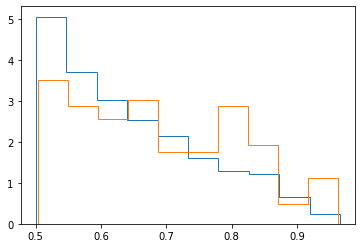

In [ ]:
plt.hist(y_score_log[np.where((df.stroke == 0 ) & (ypred == 1)),1].T, density=1, histtype="step")
plt.hist(y_score_log[np.where((df.stroke == 1 ) & (ypred == 1)),1].T, density=1,histtype="step")

In [ ]:
from sklearn.metrics import recall_score, roc_auc_score

print(accuracy_score(df.stroke, ypred))
print(recall_score(df.stroke, ypred))
print(roc_auc_score(df.stroke, y_score_log[:,1]))

0.6976516634050881
0.6715686274509803
0.7376416065911432


In [ ]:
#probamos subir el umbral a ver que pasa
umbral = 0.5
ypred_umbral = np.zeros(len(df_listo))
for i in range(len(df_listo)):
  if y_score_log[i,1] >= umbral:
    ypred_umbral[i] = 1

print(confusion_matrix(df.stroke, ypred_umbral))
print(accuracy_score(df.stroke, ypred_umbral))
print(recall_score(df.stroke, ypred_umbral))
print(roc_auc_score(df.stroke, y_score_log[:,1]))

[[2715 1169]
 [  67  137]]
0.6976516634050881
0.6715686274509803
0.7376416065911432


In [ ]:
df_listo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,hypertension,heart_disease
0,-0.896710,-0.390718,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0
1,-1.039486,0.074254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0
2,-0.886402,-0.933185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0
3,-0.742529,-0.067821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.509613,0.100085,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-0.143132,-1.372325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
4084,0.958504,-0.468213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0
4085,-0.086109,0.048422,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
4086,-0.129973,2.747841,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
peso_clases = {0:1, 1:19}
reg_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = {"n_estimators":np.arange(10,100, 10),
              "max_depth":np.arange(4, 100, 10),
              "min_samples_leaf":np.arange(1,30, 5)
             }
reg_rf.fit(df_listo, df.stroke)
#gsrf = GridSearchCV(reg_rf, param_grid, verbose=3)
rsrf = RandomizedSearchCV(reg_rf, param_grid, verbose=3, n_iter=25, random_state=42)
rsrf.fit(df_listo, df.stroke)
#ypred_gsrf = cross_val_predict(gsrf.best_estimator_, _train_scaled, t_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............
[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.910, total=   0.1s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.914, total=   0.2s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............
[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.902, total=   0.1s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.897, total=   0.2s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............
[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.896, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.864, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.848, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.861, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.847, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   16.6s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [ ]:
rsrf.best_params_

{'max_depth': 74, 'min_samples_leaf': 1, 'n_estimators': 60}

In [ ]:
ypred_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke)
yscore_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred_rsrf)

array([[3873,   11],
       [ 203,    1]])

In [ ]:
print(accuracy_score(df.stroke, ypred_rsrf))
print(recall_score(df.stroke, ypred_rsrf))
print(roc_auc_score(df.stroke, yscore_rsrf[:,1]))

0.9476516634050881
0.004901960784313725
0.6723675309464672


## Usando scoring = F1 para el randomized search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
peso_clases = {0:1, 1:19}
reg_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = {"n_estimators":np.arange(100,500, 10),
              "max_depth":np.arange(200, 500, 10),
              "min_samples_leaf":np.arange(1,30, 5)
             }
reg_rf.fit(df_listo, df.stroke)
#gsrf = GridSearchCV(reg_rf, param_grid, verbose=3)
rsrf = RandomizedSearchCV(reg_rf, param_grid, verbose=3, n_iter=25, random_state=42, scoring="f1")
rsrf.fit(df_listo, df.stroke)
#ypred_gsrf = cross_val_predict(gsrf.best_estimator_, _train_scaled, t_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.211, total=   0.8s
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.229, total=   0.8s
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.201, total=   0.8s
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............
[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.187, total=   0.8s
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............
[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.185, total=   0.8s
[CV] n_estimators=400, min_samples_leaf=11, max_depth=420 ............
[CV]  n_estimators=400, min_samples_leaf=11, max_depth=420, score=0.233, total=   1.1s
[CV] n_estimators=400, min_samples_leaf=11, max_depth=420 ............
[CV]  n_estimators=400, min_samples_leaf=11, max_depth=420, score=0.236, total=   1.1s
[CV] n_estimators=400, min_samples_leaf=11, max_depth=420 ............
[CV]  n_estimators=400, min_samples_leaf=11, max_depth=420, score=0.219, total=   1.1s
[CV] n_estimators=400, min_samples_leaf=11, max_depth=420 ............
[CV]  n_estimators=400, min_samples_leaf=11, max_dep

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.8min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [ ]:
rsrf.best_params_

{'max_depth': 340, 'min_samples_leaf': 11, 'n_estimators': 140}

In [ ]:
ypred_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke)
yscore_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred_rsrf)

array([[3473,  411],
       [ 130,   74]])

In [ ]:
dir ()

['AdaBoostClassifier',
 'ColumnTransformer',
 'DecisionTreeClassifier',
 'GradientBoostingClassifier',
 'GridSearchCV',
 'In',
 'LabelEncoder',
 'LogisticRegression',
 'ModifiedLabelEncoder',
 'OneHotEncoder',
 'Out',
 'Pipeline',
 'RandomForestClassifier',
 'RandomizedSearchCV',
 'StandardScaler',
 '_',
 '_10',
 '_12',
 '_14',
 '_15',
 '_16',
 '_18',
 '_19',
 '_20',
 '_22',
 '_23',
 '_24',
 '_26',
 '_28',
 '_29',
 '_30',
 '_32',
 '_33',
 '_34',
 '_35',
 '_37',
 '_38',
 '_40',
 '_43',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_59',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '

In [ ]:
print(accuracy_score(df.stroke, ypred_rsrf))
print(recall_score(df.stroke, ypred_rsrf))
print(roc_auc_score(df.stroke, yscore_rsrf[:,1]))

0.8676614481409002
0.3627450980392157
0.7439356535611155


## Usando AUC_roc como scoring

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
peso_clases = {0:1, 1:19}
reg_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = {"n_estimators":np.arange(100,500, 10),
              "max_depth":np.arange(200, 500, 10),
              "min_samples_leaf":np.arange(1,600, 5)
             }
reg_rf.fit(df_listo, df.stroke)
#gsrf = GridSearchCV(reg_rf, param_grid, verbose=3)
rsrf = RandomizedSearchCV(reg_rf, param_grid, verbose=3, n_iter=35, random_state=42, scoring="roc_auc")
rsrf.fit(df_listo, df.stroke)
#ypred_gsrf = cross_val_predict(gsrf.best_estimator_, _train_scaled, t_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.731, total=   1.0s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.755, total=   1.0s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.683, total=   0.9s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........
[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.707, total=   1.0s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........
[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.728, total=   1.0s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, max_depth=470, score=0.726, total=   0.4s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, max_depth=470, score=0.749, total=   0.4s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, max_depth=470, score=0.684, total=   0.4s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, 

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [ ]:
rsrf.best_params_

{'max_depth': 210, 'min_samples_leaf': 61, 'n_estimators': 410}

In [ ]:
ypred_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke)
yscore_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred_rsrf)

array([[2940,  944],
       [  81,  123]])

In [ ]:
print(accuracy_score(df.stroke, ypred_rsrf))
print(recall_score(df.stroke, ypred_rsrf))
print(roc_auc_score(df.stroke, yscore_rsrf[:,1]))

0.74926614481409
0.6029411764705882
0.7490685769673471


In [ ]:
print(roc_auc_score(df.stroke, ypred_rsrf))

0.6799463863815352


# Boosting


## AdaBoost


In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

#dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

ada_clf = AdaBoostClassifier(LogisticRegression(), algorithm="SAMME.R", random_state=42)
ada_clf.fit(df_listo, df.stroke)
param_grid = {"n_estimators":np.arange(10,300, 10),
              "learning_rate": np.linspace(0.1, 1.5, 40)
             }

rs_ada = RandomizedSearchCV(ada_clf, param_grid, verbose=3, n_iter=15, random_state=42, scoring="roc_auc")
rs_ada.fit(df_listo, df.stroke)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.742, total=   1.2s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.775, total=   1.1s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.702, total=   1.2s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............
[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.732, total=   1.1s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............
[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.718, total=   1.1s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.739, total=   1.6s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.775, total=   1.6s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.705, total=   2.0s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.730, total=   1.7s
[CV] n_estimators=210, learning_rat

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.1min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=LogisticRegression(C=1.0,
                                                                                  class_weight=None,
                                                                                  dual=False,
                                                                                  fit_intercept=True,
                                                                                  intercept_scaling=1,
                                                                                  l1_ratio=None,
                                                                                  max_iter=100,
                                                                                  multi_class='auto',
                                                                                  n_jobs=None,
       

In [ ]:
rs_ada.best_params_

{'learning_rate': 0.423076923076923, 'n_estimators': 150}

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
ypred_rs_ada = cross_val_predict(rs_ada.best_estimator_, df_listo, df.stroke)
yscore_rs_ada = cross_val_predict(rs_ada.best_estimator_, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred_rs_ada)

array([[3884,    0],
       [ 204,    0]])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
print(accuracy_score(df.stroke, ypred_rs_ada))
print(recall_score(df.stroke, ypred_rs_ada))
print(roc_auc_score(df.stroke, yscore_rs_ada[:,1]))

0.9500978473581213
0.0
0.7328582823448638


## GradientBoost

# Red Neuronal Artificial, ANN

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, t_train, t_val = train_test_split(df_listo, df.stroke, test_size=0.15)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Definimos una capa especial, que es la entrada del modelo:
input_ = keras.layers.Input(shape=[df_listo.shape[1]])
#Luego se instancia cada capa y se aplica como una función a la salida de la capa anterior

hidden1 = keras.layers.Dense(40, activation="relu")(input_)
drop1 = keras.layers.Dropout(0.2)(hidden1)
hidden2 = keras.layers.Dense(20, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.2)(hidden2)
hidden3 = keras.layers.Dense(10, activation="relu")(drop2)
drop3 = keras.layers.Dropout(0.2)(hidden3)
output = keras.layers.Dense(1, activation="sigmoid")(drop3)

#Cuando se haya llegado a las las salidas, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
early = keras.callbacks.EarlyStopping(patience=17, restore_best_weights=True)
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy",])

In [ ]:
#Cuantas capas hay?
model.layers

In [ ]:
#cómo es el modelo?
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 40)                680       
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0     

In [ ]:
pesos = {0:1.0, 1:25}
history = model.fit(epochs=100, batch_size=32, x=X_train, y= t_train, validation_data=(X_val, t_val), 
                    callbacks=[early,], class_weight=pesos)

Epoch 1/100
109/109 [==============================] - 1s 4ms/step - loss: 1.5144 - accuracy: 0.2784 - val_loss: 0.8548 - val_accuracy: 0.0440
Epoch 2/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4917 - accuracy: 0.1229 - val_loss: 0.8144 - val_accuracy: 0.0651
Epoch 3/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4852 - accuracy: 0.1503 - val_loss: 0.8259 - val_accuracy: 0.0961
Epoch 4/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4536 - accuracy: 0.1957 - val_loss: 0.8270 - val_accuracy: 0.1678
Epoch 5/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4396 - accuracy: 0.2522 - val_loss: 0.7874 - val_accuracy: 0.3599
Epoch 6/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4669 - accuracy: 0.3621 - val_loss: 0.7999 - val_accuracy: 0.3518
Epoch 7/100
109/109 [==============================] - 0s 3ms/step - loss: 1.4377 - accuracy: 0.4024 - val_loss: 0.7984 - val_accuracy: 0.4039

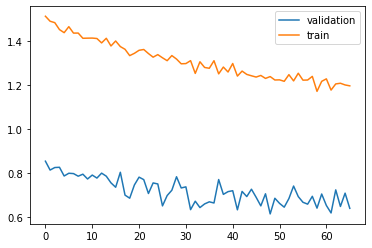

In [ ]:
history.history.keys()
plt.plot(history.history.get('val_loss'), label="validation")
plt.plot(history.history.get('loss'), label="train")
plt.legend()

In [ ]:
y_pred_score = model.predict(X_val)
y_pred = np.zeros(len(y_pred_score))
for i in range(len(y_pred_score)):
    if(y_pred_score[i,0] > 0.5 ):
        y_pred[i] = 1

In [ ]:
model.evaluate(X_val, t_val)

20/20 [==============================] - 0s 1ms/step - loss: 0.6148 - accuracy: 0.6091


[0.6148428916931152, 0.6091205477714539]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(t_val, y_pred)

array([[352, 235],
       [  5,  22]])

In [ ]:
print(accuracy_score(t_val, y_pred))
print(recall_score(t_val, y_pred))
print(roc_auc_score(t_val, y_pred_score))

0.6091205211726385
0.8148148148148148
0.7700170357751277


In [ ]:
#No correr
confusion_matrix(df.stroke, y_pred)#no olvidar que use una red con dos capas dense una de 300 y otra de 100 y pesos 0:1 1:100
#[1657, 2227],
#[   9,  195]

array([[2645, 1239],
       [  48,  156]])